The aim of this notebook is to perform a quick test for an update of the model or a new optimization procedure.
To test a model update, each cell of this notebook must run with correct results.
To test a new optimization procedure, a new dedicated cell must be created on the same model as the previous ones.

As this pipeline consist in only one instance solved by each procedure once, it statisticaly has no meaning. For a statisticaly meaningful test pipeline, please run the Test pipeline notebook (heavily time consuming). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pathlib
from scipy import stats

from tyssue.generation import generate_ring
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.config.draw import sheet_spec
from tyssue.draw.plt_draw import sheet_view
from tyssue.io.hdf5 import save_datasets

from tyssue_taylor.adjusters.adjust_annular import set_init_point, prepare_tensions, adjust_tensions
from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.segmentation.segment2D import generate_ring_from_image, normalize_scale
from tyssue_taylor.adjusters.force_inference import infer_forces

Error: IPOPT shared library failed to import


Using TensorFlow backend.


### Control randomness

In [2]:
def get_sequence(seed, theta, shape):
    np.random.seed(seed)
    
    return np.random.normal(1.0, theta, shape)
seed = 1553

Generate the theoritical organoïd

In [23]:
organo = generate_ring(10, 110, 150)
Nf= organo.Nf
geom.update_all(organo)
#alpha as proposed in the doc (in french) https://www.sharelatex.com/read/zdxptpnrryhc
alpha = 1 + 1/(20*(organo.settings['R_out']-organo.settings['R_in']))


# Model parameters or specifications
specs = {
    'face':{
        'is_alive': 1,
        'prefered_area':  alpha*organo.face_df.area, 
        'area_elasticity': 1.,},
    'edge':{        
        'ux': 0.,
        'uy': 0.,
        'uz': 0.,
        'line_tension': 0.1,
        'is_active': 1
        },
    'vert':{
        'adhesion_strength': 0.,
        'x_ecm': 0.,
        'y_ecm': 0.,
        'is_active': 1
        },
    'settings': {
        'lumen_elasticity': 0.1,
        'lumen_prefered_vol': organo.settings['lumen_volume'],
        'lumen_volume': organo.settings['lumen_volume']
        }
    }

organo.update_specs(specs, reset=True)
normalize_scale(organo, geom, refer='edges')
geom.update_all(organo)

symetric_tensions = 10*set_init_point(organo.settings['R_in'], organo.settings['R_out'], organo.Nf, alpha)
sin_mul = 1+(np.sin(np.linspace(0, 2*np.pi, organo.Nf, endpoint=False)))**2
organo.face_df.prefered_area *= np.random.normal(1.0, 0.05, organo.Nf)
organo.edge_df.line_tension = prepare_tensions(organo, symetric_tensions)
organo.edge_df.loc[:Nf-1, 'line_tension'] *= sin_mul

organo.vert_df[['x_ecm', 'y_ecm']] = organo.vert_df[['x', 'y']]

organo.vert_df.loc[organo.basal_verts, 'adhesion_strength'] = 0.01

new_tensions = organo.edge_df.line_tension

organo.edge_df.loc[:,'line_tension'] = new_tensions
                                                          
res = Solver.find_energy_min(organo, geom, model)                                                       

Reseting datasets values with new specs


Creating a printing function

In [24]:
symetric_tensions

array([0.0133426 , 0.0133426 , 0.0133426 , 0.0133426 , 0.0133426 ,
       0.0133426 , 0.0133426 , 0.0133426 , 0.0133426 , 0.0133426 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00773079, 0.00773079, 0.00773079, 0.00773079, 0.00773079,
       0.00773079, 0.00773079, 0.00773079, 0.00773079, 0.00773079])

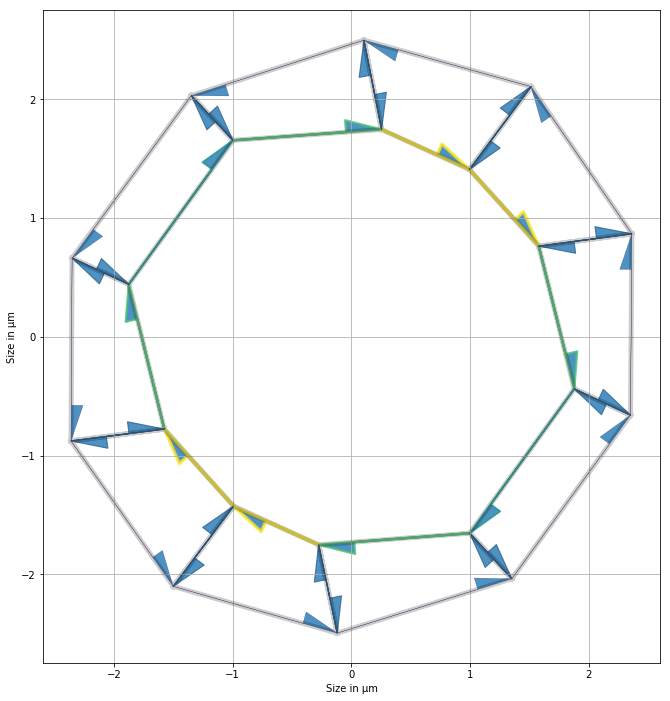

In [25]:
def print_tensions(exp_organo, th_organo):
    draw_specs = sheet_spec()
    tension_max = np.max(exp_organo.edge_df.line_tension.values.copy())
    edge_color = 1/tension_max*exp_organo.edge_df.line_tension.values.copy()
    cmap = plt.cm.get_cmap('viridis')
    edge_cmap = cmap(edge_color)
    draw_specs['vert']['visible'] = False
    draw_specs['edge']['color'] = edge_cmap
    draw_specs['edge']['width'] = 0.25+3*edge_color
    fig, ax = quick_edge_draw(th_organo, lw=5, c='k', alpha=0.2)
    fig, ax = sheet_view(exp_organo, ax=ax, **draw_specs)
    fig.set_size_inches(12, 12)
    plt.xlabel('Size in µm')
    plt.ylabel('Size in µm')
    
print_tensions(organo, organo)

Define the optimization parameters

In [26]:
energy_opt = {'options': {'gtol': 1e-5, 'ftol': 1e-5}}


bfgs_opt = {'method': 'bfgs','options': {'gtol':1e-1,'ftol': 1e-5}}
trf_opt = {'bounds': ([-1e-8]*(organo.Nf),[1000]*(organo.Nf)), 
           'method': 'trf','xtol':1e-5,'ftol': 1e-5, 'verbose': 2}
lm_opt = {'method': 'lm','xtol':1e-5,'ftol': 1e-5, 'verbose': 1}
psqp_opt = {'lb': 0, 'ub': 1e6, 'method': 'dist_PSQP', #'callback': printx,
            'output_path': './PSQP_areas.out'}

reg_weight = 1e-3
theta = 0.02

# Force inference with ONLY TENSIONS solved with NNLS

Energy before optimization:  1.733148080426388
Solving time: 1.181090999999995
Energy after optimization:  1.703123795959539
Distance: 4.53245226484389


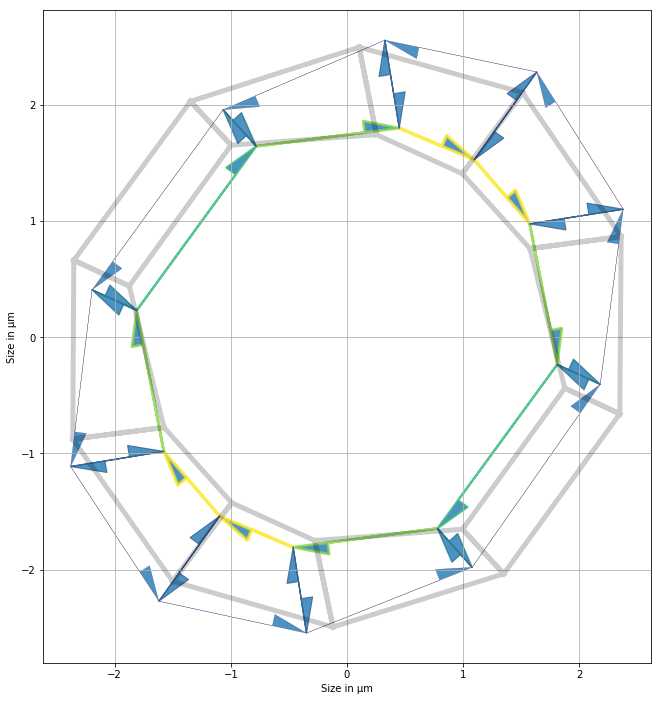

In [40]:
initial_guess = infer_forces(organo, 'NNLS', sup_param='')
start = time.clock()
tensions_organo = organo.copy()
tensions_organo.edge_df.line_tension = prepare_tensions(tensions_organo,
                                                        0.1*initial_guess['tensions'])
print('Energy before optimization: ', model.compute_energy(tensions_organo, False))
Solver.find_energy_min(tensions_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Energy after optimization: ', model.compute_energy(tensions_organo, False))
print_tensions(tensions_organo, organo)
print('Distance: ' + str(np.sum(np.linalg.norm(_distance(organo, tensions_organo), axis=1))))

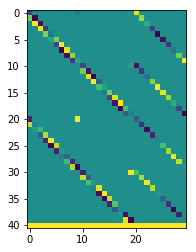

In [8]:
from tyssue_taylor.adjusters.force_inference import _coef_matrix
plt.imshow(_coef_matrix(organo, sup_param=''))

In [9]:
_coef_matrix(tensions_organo, sup_param='')[-1]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
tensions_organo.edge_df.line_tension[:3*organo.Nf].mean()

0.989327939593737

In [11]:
2.8*0.033

0.0924

Comparaison vraies tensions / tensions obtenues

R value : 0.9870694454699668 
Standard error : 0.12572457283945132


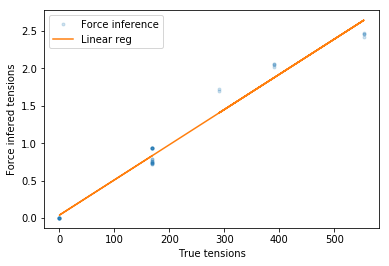

In [12]:
true_t = organo.edge_df.line_tension
opt_t = tensions_organo.edge_df.line_tension
slope, intercept, r_value, p_value, std_err = stats.linregress(true_t, opt_t)
plt.plot(true_t, opt_t, '.', alpha=0.2)
plt.plot(true_t, intercept+slope*true_t, '-')
plt.legend(('Force inference', 'Linear reg'), loc='upper left')
plt.xlabel('True tensions')
plt.ylabel('Force infered tensions')
std = np.sum(np.power(intercept+slope*true_t-opt_t, 2))
print('R value :', r_value, '\nStandard error :', (std/organo.Ne)**0.5)

# Force inference with PRESSIONS solved with NNLS

Energy before optimization:  1153.1867387211316
Solving time: 0.5170239999999993
Energy after optimization:  1134.867284439846
Distance: 0.3112639156632402


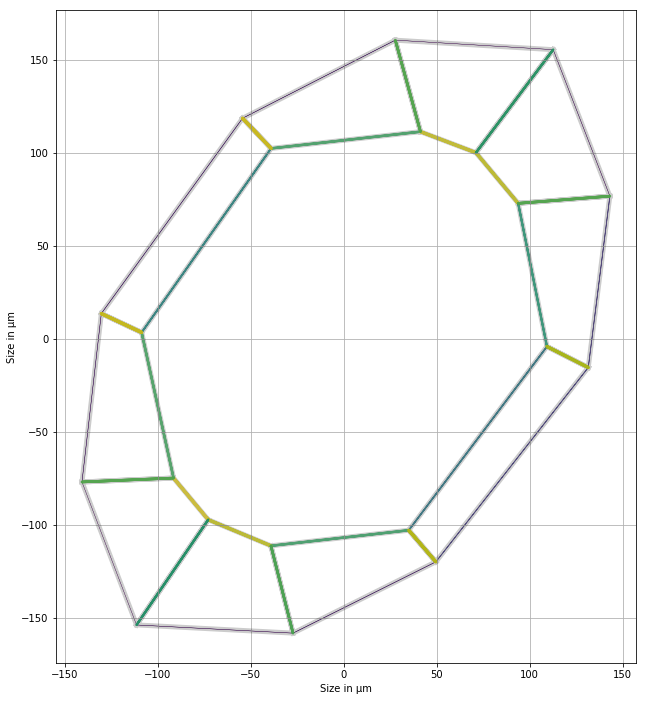

In [27]:
initial_guess = infer_forces(organo, 'NNLS', sup_param='pressions')
start = time.clock()
pressions_organo = organo.copy()
pressions_organo.edge_df.line_tension = prepare_tensions(pressions_organo,
                                                         initial_guess['tensions'])
print('Energy before optimization: ', model.compute_energy(pressions_organo, False))
Solver.find_energy_min(pressions_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Energy after optimization: ', model.compute_energy(pressions_organo, False))
print_tensions(pressions_organo, organo)
print('Distance: ' + str(np.sum(np.linalg.norm(_distance(organo, pressions_organo), axis=1))))

Comparaison des vraies tensions et des tensions inférées

R value : 0.6578133360827043 
Standard error : 0.4736574568789383


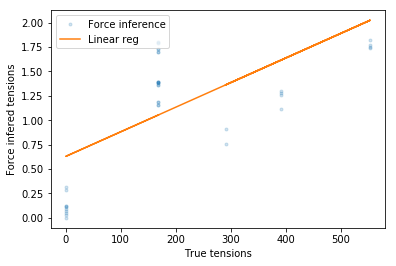

In [28]:
true_t = organo.edge_df.line_tension
opt_t = pressions_organo.edge_df.line_tension
slope, intercept, r_value, p_value, std_err = stats.linregress(true_t, opt_t)
plt.plot(true_t, opt_t, '.', alpha=0.2)
plt.plot(true_t, intercept+slope*true_t, '-')
plt.legend(('Force inference', 'Linear reg'), loc='upper left')
plt.xlabel('True tensions')
plt.ylabel('Force infered tensions')
std = np.sum(np.power(intercept+slope*true_t-opt_t, 2))
print('R value :', r_value, '\nStandard error :', (std/organo.Ne)**0.5)

# Force inference with AREAS solved with NNLS

Energy before optimization:  3.0395321555475223
Solving time: 6.953938000000008
Energy after optimization:  1.5182786595988884


8.60077528858147

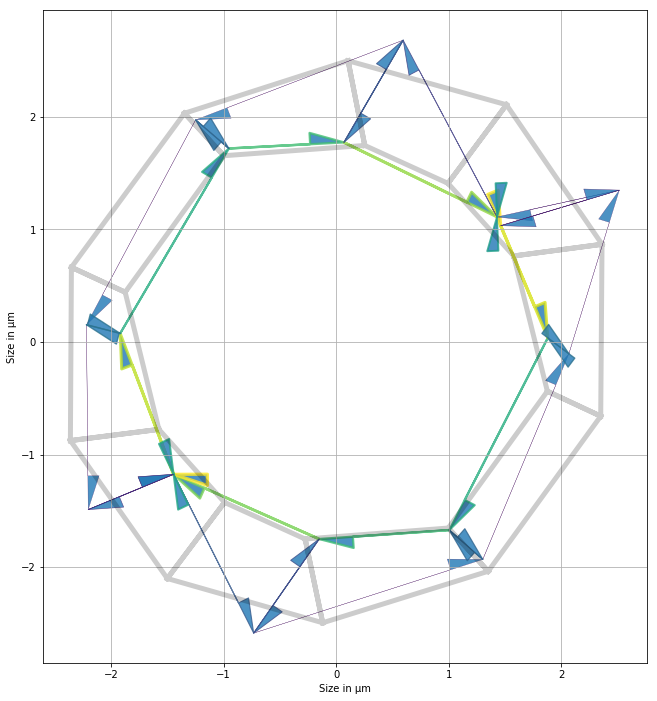

In [38]:
initial_guess = infer_forces(organo, 'NNLS', sup_param='areas')
start = time.clock()
areas_organo = organo.copy()
areas_organo.edge_df.line_tension = prepare_tensions(areas_organo, initial_guess['tensions'])
areas_organo.face_df.prefered_area = areas_organo.face_df.area - initial_guess['areas'][:-1]
print('Energy before optimization: ', model.compute_energy(areas_organo, False))
Solver.find_energy_min(areas_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Energy after optimization: ', model.compute_energy(areas_organo, False))
print_tensions(areas_organo, organo)
np.sum(np.linalg.norm(_distance(organo, areas_organo), axis=1))

Comparaison des vraies tensions et des tensions inférées

In [39]:
areas_organo.edge_df.line_tension.mean()

0.09444343145467979

R value : 0.917474075364865 
Standard error : 0.002877677977412922


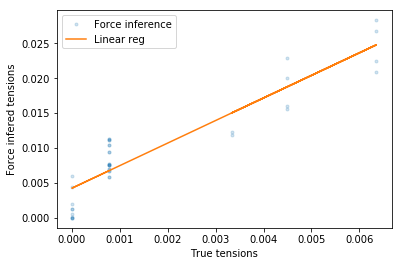

In [48]:
true_t = organo.edge_df.line_tension
opt_t = areas_organo.edge_df.line_tension
slope, intercept, r_value, p_value, std_err = stats.linregress(true_t, opt_t)
plt.plot(true_t, opt_t, '.', alpha=0.2)
plt.plot(true_t, intercept+slope*true_t, '-')
plt.legend(('Force inference', 'Linear reg'), loc='upper left')
plt.xlabel('True tensions')
plt.ylabel('Force infered tensions')
std = np.sum(np.power(intercept+slope*true_t-opt_t, 2))
print('R value :', r_value, '\nStandard error :', (std/organo.Ne)**0.5)

Comparaison des vraies aires de préference et des aires de préference trouvées

R value : 0.996597552617108 
Standard error : 0.0034764772617849205


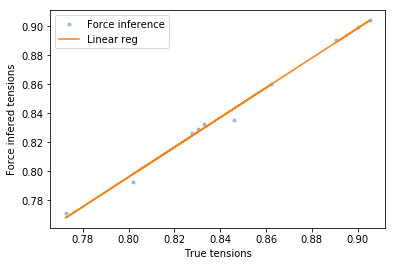

In [50]:
true_a = organo.face_df.prefered_area
opt_a = areas_organo.face_df.prefered_area
slope, intercept, r_value, p_value, std_err = stats.linregress(true_a, opt_a)
plt.plot(true_a, opt_a, '.', alpha=0.4)
plt.plot(true_a, intercept+slope*true_a, '-')
plt.legend(('Force inference', 'Linear reg'), loc='upper left')
plt.xlabel('True tensions')
plt.ylabel('Force infered tensions')
std = np.sum(np.power(intercept+slope*true_a-opt_a, 2))
print('R value :', r_value, '\nStandard error :', (std/organo.Nf)**0.5)

# Force inference with AREAS solved with basic linear algebra

6.64525809144088e-15
Energy before optimization:  330.7624501616112
Gradient: 13.66531756906951
Solving time: 41.218903
Energy after optimization:  -1799.8588666433388
Gradient: 231.81338945736775


2374.899746654968

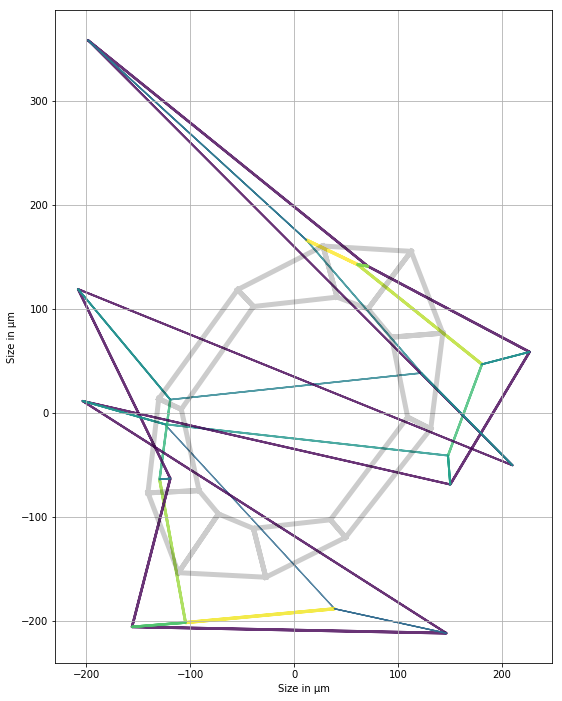

In [32]:
initial_guess = infer_forces(organo, 'LINALG', sup_param='areas')
start = time.clock()
linalg_organo = organo.copy()
linalg_organo.edge_df.line_tension = prepare_tensions(linalg_organo, initial_guess['tensions'])
linalg_organo.face_df.prefered_area = linalg_organo.face_df.area - initial_guess['areas'][:-1]
print('Energy before optimization: ', model.compute_energy(linalg_organo, False))
print('Gradient:', np.linalg.norm(model.compute_gradient(linalg_organo)))
Solver.find_energy_min(linalg_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Energy after optimization: ', model.compute_energy(linalg_organo, False))
print('Gradient:', np.linalg.norm(model.compute_gradient(linalg_organo)))
print_tensions(linalg_organo, organo)
np.sum(np.linalg.norm(_distance(organo, linalg_organo), axis=1))

In [33]:
a = infer_forces(organo, 'LINALG', sup_param='areas')

6.64525809144088e-15


In [36]:
a['tensions']

array([ 4.5942884 ,  2.95986108,  8.59420406,  7.47261209,  5.75946256,
        3.8350374 ,  4.01774422,  8.78938381,  7.84166023,  6.03866149,
       -6.87758211, -7.15963368, -8.71166914, -8.23774773, -7.73653698,
       -6.50278718, -6.27962826, -8.10900097, -8.02658396, -8.05931015,
        5.00305714,  4.53033451,  2.98985508,  6.3032946 ,  3.82484049,
        4.33638892,  4.01726758,  3.40067083,  7.090757  ,  4.30109869])

In [35]:
linalg_organo.edge_df.line_tension[:3*organo.Nf].mean()

1.0000000000000009

Comparaison des vraies tensions et des tension trouvées

R value : 0.5525168933647475 
Standard error : 3.0996024580658625


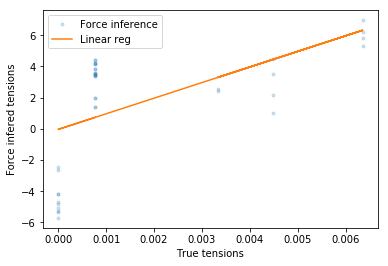

In [58]:
true_t = organo.edge_df.line_tension
opt_t = linalg_organo.edge_df.line_tension
slope, intercept, r_value, p_value, std_err = stats.linregress(true_t, opt_t)
plt.plot(true_t, opt_t, '.', alpha=0.2)
plt.plot(true_t, intercept+slope*true_t, '-')
plt.legend(('Force inference', 'Linear reg'), loc='upper left')
plt.xlabel('True tensions')
plt.ylabel('Force infered tensions')
std = np.sum(np.power(intercept+slope*true_t-opt_t, 2))
print('R value :', r_value, '\nStandard error :', (std/organo.Ne)**0.5)

Comparaison des vraies aires de préference et des aires de préference trouvées

R value : -0.27926731364224117 
Standard error : 0.800074125095403


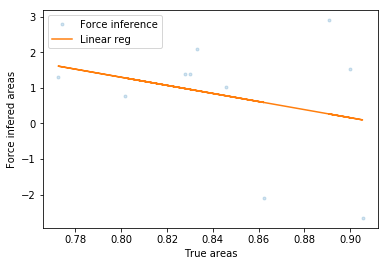

In [59]:
true_a = organo.face_df.prefered_area
opt_a = linalg_organo.face_df.prefered_area
slope, intercept, r_value, p_value, std_err = stats.linregress(true_a, opt_a)
plt.plot(true_a, opt_a, '.', alpha=0.2)
plt.plot(true_a, intercept+slope*true_a, '-')
plt.legend(('Force inference', 'Linear reg'), loc='upper left')
plt.xlabel('True areas')
plt.ylabel('Force infered areas')
std = np.sum(np.power(intercept+slope*true_a-opt_a, 2))
print('R value :', r_value, '\nStandard error :', (std/organo.Ne)**0.5)

# Force inference with AREAS solved with basic linear algebra without the last constraint (norm 1)

Pas le droit car ça fait 4n+1 variables pour 4n équations...

# Force inference with AREAS solved with QP without the last constraint (norm 1)

(41, 30) (41, 11)
Energy before optimization:  4.0787710952289534e-05
Solving time: 0.44294200000000217
Energy after optimization:  4.1147425715686245e-05


0.0032616591346021407

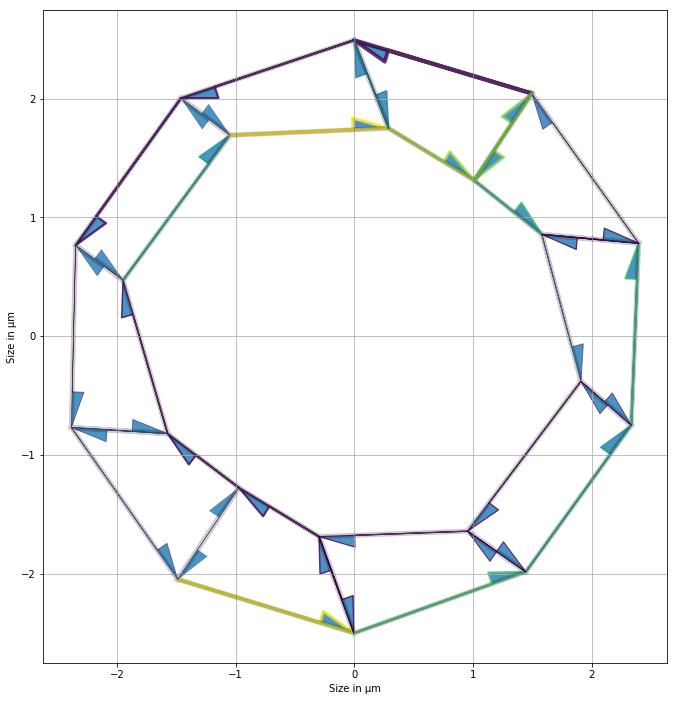

In [79]:
initial_guess = infer_forces(organo, 'MP', sup_param='areas', no_scale=True)
start = time.clock()
mp_organo = organo.copy()
mp_organo.edge_df.line_tension = prepare_tensions(mp_organo, initial_guess['tensions'])
mp_organo.face_df.prefered_area = mp_organo.face_df.area - initial_guess['areas'][:-1]
print('Energy before optimization: ', model.compute_energy(mp_organo, False))
Solver.find_energy_min(mp_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Energy after optimization: ', model.compute_energy(mp_organo, False))
print_tensions(mp_organo, organo)
np.sum(np.linalg.norm(_distance(organo, mp_organo), axis=1))

Comparaison des vraies aires de préference et des aires de préference trouvées

R value : 0.050600245771717726 
Standard error : 9.368840084431781e-13


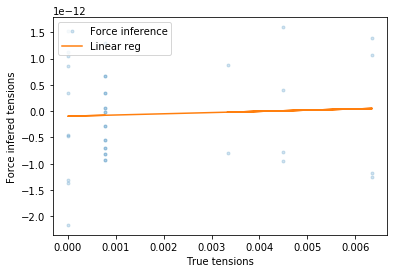

In [82]:
true_t = organo.edge_df.line_tension
opt_t = mp_organo.edge_df.line_tension
slope, intercept, r_value, p_value, std_err = stats.linregress(true_t, opt_t)
plt.plot(true_t, opt_t, '.', alpha=0.2)
plt.plot(true_t, intercept+slope*true_t, '-')
plt.legend(('Force inference', 'Linear reg'), loc='upper left')
plt.xlabel('True tensions')
plt.ylabel('Force infered tensions')
std = np.sum(np.power(intercept+slope*true_t-opt_t, 2))
print('R value :', r_value, '\nStandard error :', (std/organo.Ne)**0.5)

Comparaison des vraies aires de préference et des aires de préference trouvées

R value : 0.9999551548486445 
Standard error : 0.00019452209031272651


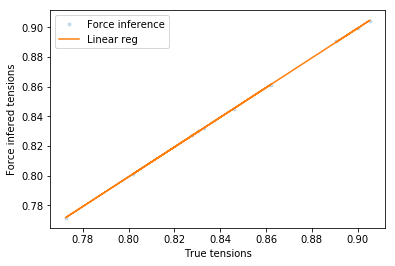

In [83]:
true_a = organo.face_df.prefered_area
opt_a = mp_organo.face_df.prefered_area
slope, intercept, r_value, p_value, std_err = stats.linregress(true_a, opt_a)
plt.plot(true_a, opt_a, '.', alpha=0.2)
plt.plot(true_a, intercept+slope*true_a, '-')
plt.legend(('Force inference', 'Linear reg'), loc='upper left')
plt.xlabel('True tensions')
plt.ylabel('Force infered tensions')
std = np.sum(np.power(intercept+slope*true_a-opt_a, 2))
print('R value :', r_value, '\nStandard error :', (std/organo.Ne)**0.5)

# Comparaison des tensions obtenues avec l'inférence prenant en compte les pressions ou les aires

Text(0,0.5,'Force infered tensions')

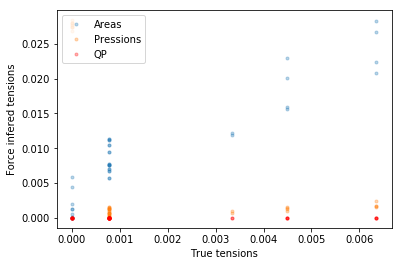

In [87]:
true_t = organo.edge_df.line_tension
area_t = areas_organo.edge_df.line_tension
mp_t = mp_organo.edge_df.line_tension
pressions_t = pressions_organo.edge_df.line_tension
plt.plot(true_t, area_t, '.',
         true_t, pressions_t, '.',
         true_t, mp_t, 'r.',
         alpha=0.3)

plt.legend(('Areas', 'Pressions', 'QP'), loc='upper left')
plt.xlabel('True tensions')
plt.ylabel('Force infered tensions')

Text(0,0.5,'Area FI')

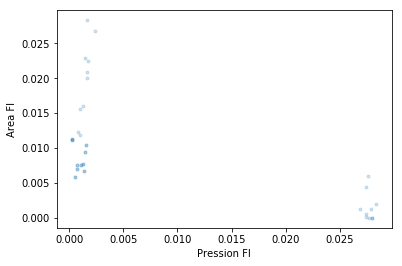

In [85]:
area_t = areas_organo.edge_df.line_tension
pressions_t = pressions_organo.edge_df.line_tension
plt.plot(pressions_t, area_t, '.',
         alpha=0.2)

plt.xlabel('Pression FI')
plt.ylabel('Area FI')

Text(0,0.5,'QP FI')

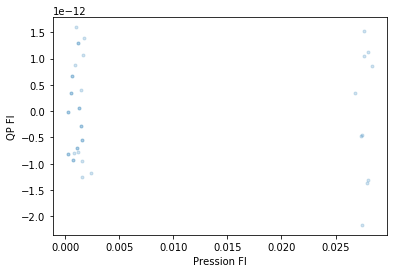

In [86]:
area_t = areas_organo.edge_df.line_tension
mp_t = mp_organo.edge_df.line_tension
plt.plot(pressions_t, mp_t, '.',
         alpha=0.2)

plt.xlabel('Pression FI')
plt.ylabel('QP FI')

In [11]:
from tyssue_taylor.adjusters.adjust_annular import adjust_areas
areas_organo = organo.copy()
print('Energy before optimization: ', model.compute_energy(areas_organo, False))
opt_areas = adjust_areas(areas_organo, organo.face_df.area.values,
                         initial_guess,
                         energy_opt, **psqp_opt)
areas_organo.face_df.prefered_area = opt_areas.x
areas_organo.edge_df.line_tension = prepare_tensions(areas_organo, initial_guess)
Solver.find_energy_min(areas_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Energy after optimization: ', model.compute_energy(areas_organo, False))
print_tensions(areas_organo, organo)

Energy before optimization:  1.250873677761331


AttributeError: 'dict' object has no attribute 'x'

Solving time: 4544.368473
Energy after optimization:  0.19595661634609404


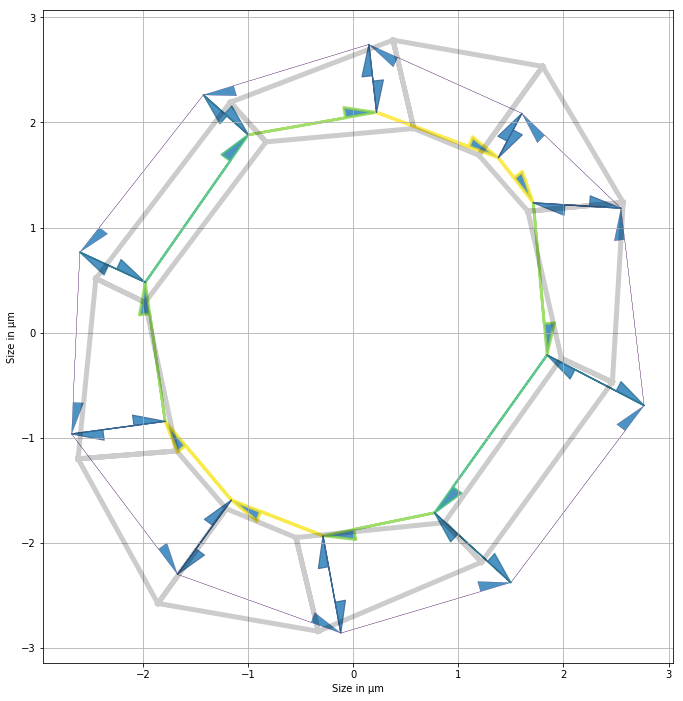

In [12]:
areas_organo.face_df.prefered_area = opt_areas['x']
areas_organo.edge_df.line_tension = prepare_tensions(areas_organo, initial_guess)
Solver.find_energy_min(areas_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Energy after optimization: ', model.compute_energy(areas_organo, False))
print_tensions(areas_organo, organo)

In [32]:
organo.face_df.area.values

array([1.08988988, 1.10446245, 1.07437254, 1.035051  , 1.01169758,
       1.04075539, 1.03739242, 0.99837928, 1.04410112, 1.09257738])

5.244653773356242


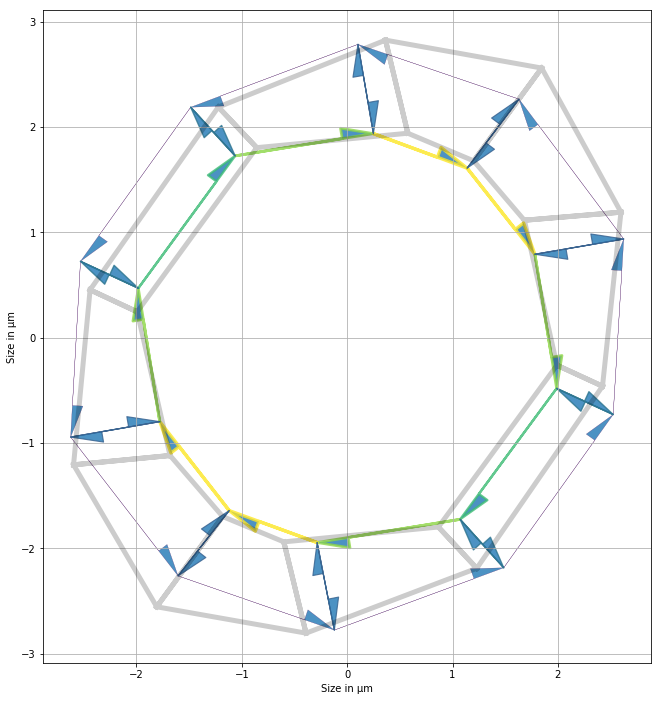

In [13]:
test_organo = organo.copy()
test_organo.edge_df.line_tension = prepare_tensions(test_organo, initial_guess)
test_organo.face_df.prefered_area = areas_opt
Solver.find_energy_min(test_organo, geom, model)
print(np.sum(np.linalg.norm(_distance(test_organo, organo), axis=1)))
print_tensions(test_organo, organo)